In [1]:
from collections import Counter
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/titanic'

In [3]:
train_df  = pd.read_csv(f'{DATA_PATH}/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
def cal_survival_rate(df, column):
    
    survive_rate = []
    not_survive_rate = []
    
    for col in sorted(df[column].unique()):
        
        denominator = df[df[column] == col]
        numerator   = df[(df[column] == col) & (df['Survived'] == 0)]
        
        not_survive = len(numerator) * 100 / len(denominator)
        not_survive_rate.append(not_survive)
        survive_rate.append(100 - not_survive)
        
    return survive_rate, not_survive_rate


def draw_barplot(ax, x, y, title = None):
    
    sns.barplot(x = x, y = y, ax = ax)
    for idx in ax.containers: 
        ax.bar_label(idx, )
        
    if not title == None: ax.set_title(f'{title}')

    
ages2decade = lambda x: (x // 10 * 10)

In [5]:
le                   = LabelEncoder()
train_df['Embarked'] = le.fit_transform(train_df['Embarked'])
train_df['Sex']      = le.fit_transform(train_df['Sex'])
train_df['Age']      = train_df['Age'].apply(ages2decade)

/tmp/ipykernel_1534219/3314600252.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), cmap = 'Blues', annot = True)


<Axes: >

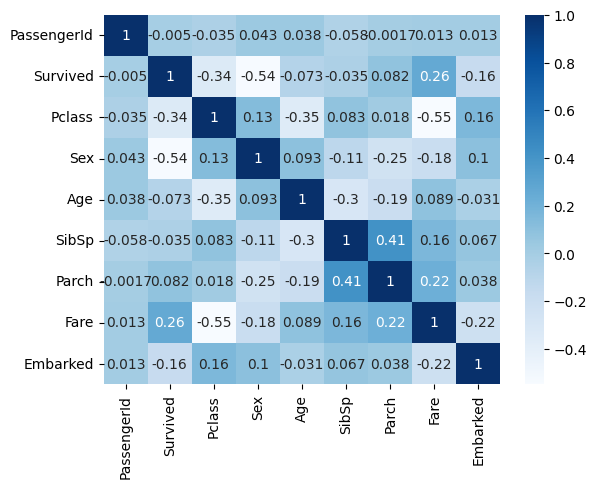

In [6]:
sns.heatmap(train_df.corr(), cmap = 'Blues', annot = True)

In [7]:
train_df = train_df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'SibSp'], axis = 1)
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df = train_df.dropna(axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


<Axes: >

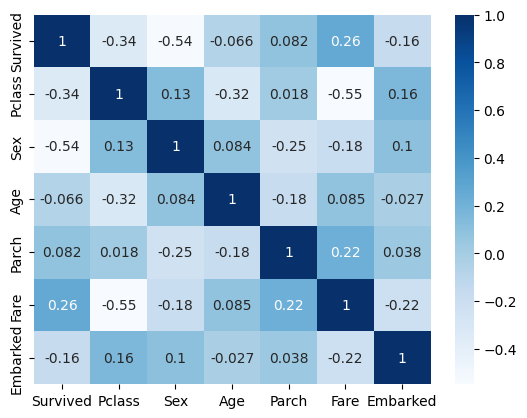

In [8]:
sns.heatmap(train_df.corr(), cmap = 'Blues', annot = True)

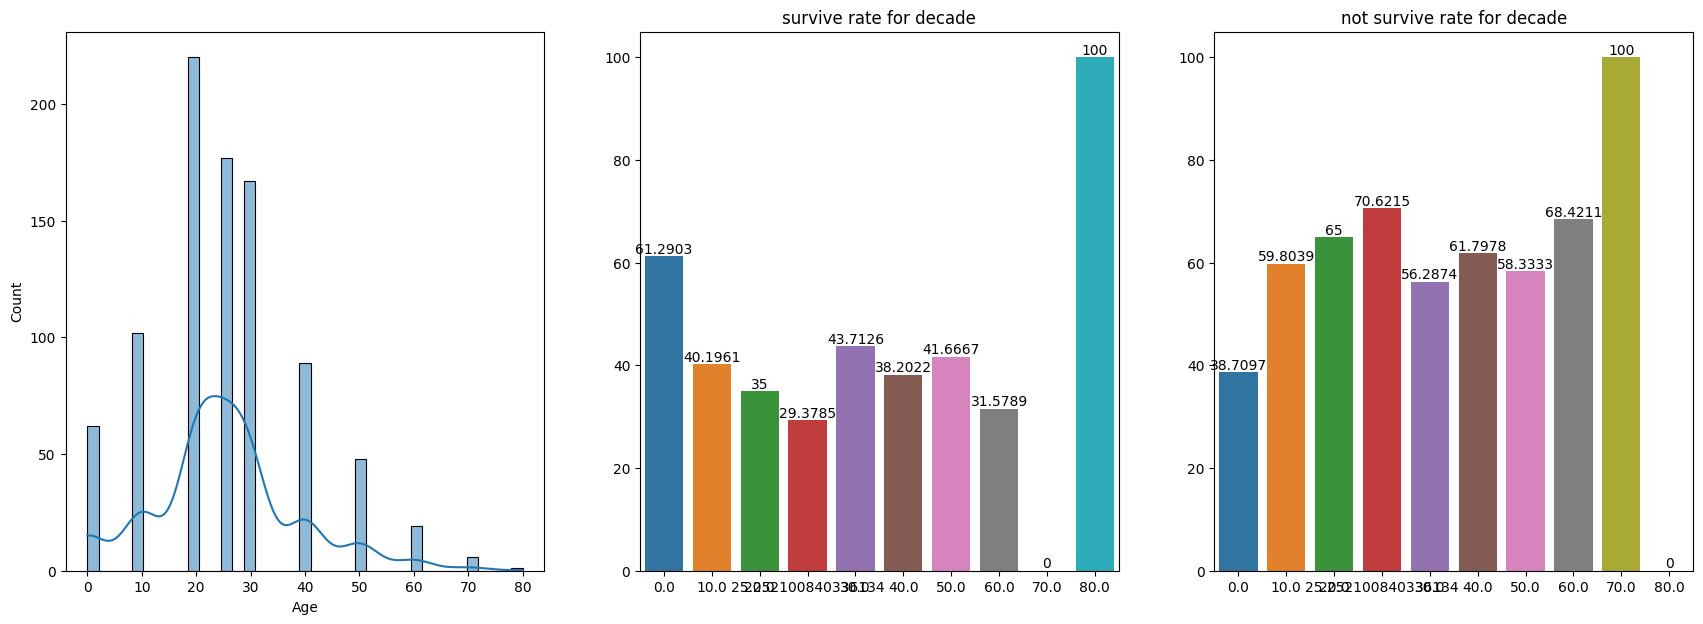

In [9]:
decades              = train_df.dropna()['Age']
survive, not_survive = cal_survival_rate(train_df, 'Age')

_, ax = plt.subplots(1, 3, figsize = (21, 7))
sns.histplot(decades, kde = True, ax = ax[0])

draw_barplot(ax[1], sorted(decades.unique()),     survive,     'survive rate for decade')
draw_barplot(ax[2], sorted(decades.unique()), not_survive, 'not survive rate for decade')

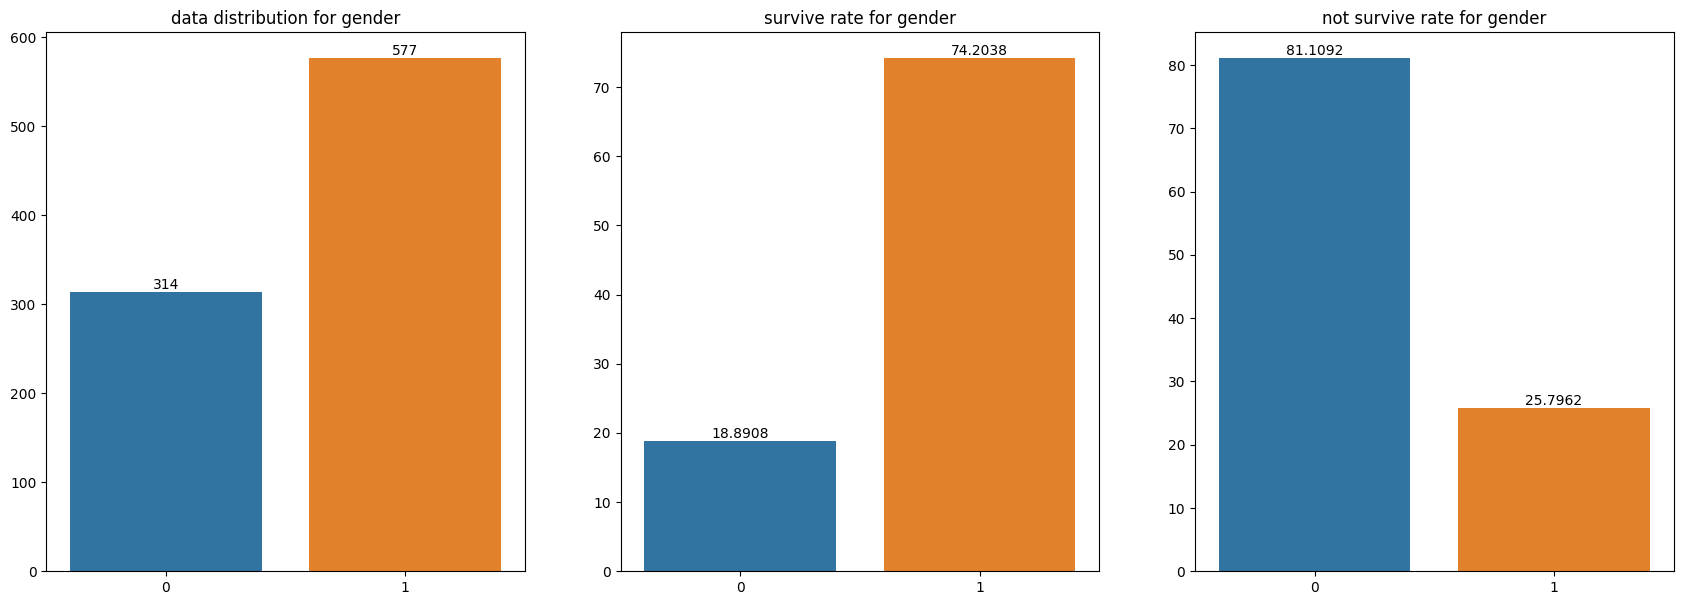

In [10]:
gender_cnt           = train_df['Sex'].value_counts()
survive, not_survive = cal_survival_rate(train_df, 'Sex')

_, ax = plt.subplots(1, 3, figsize = (21, 7))

draw_barplot(ax[0], gender_cnt.index, gender_cnt.values, title = 'data distribution for gender')
draw_barplot(ax[1], gender_cnt.index,           survive, title =      'survive rate for gender')
draw_barplot(ax[2], gender_cnt.index,       not_survive, title =  'not survive rate for gender')

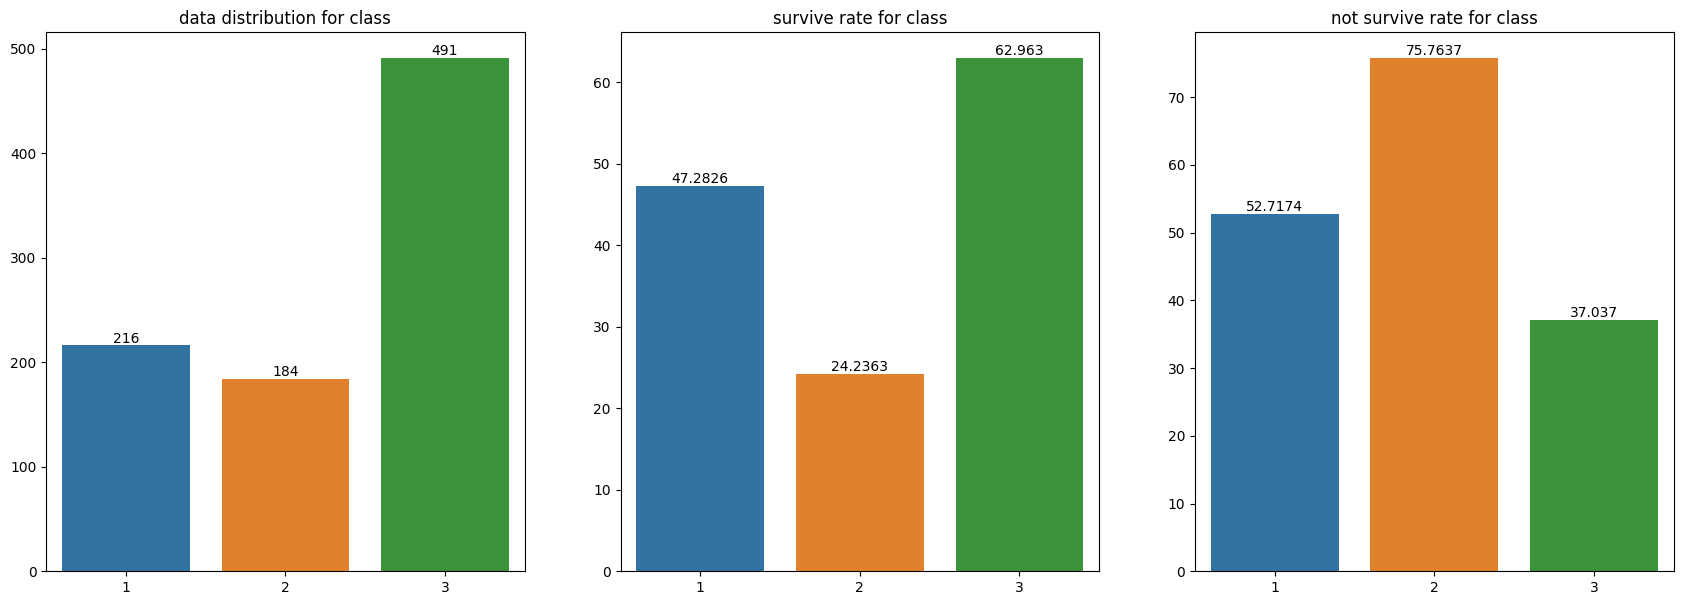

In [11]:
class_cnt            = train_df['Pclass'].value_counts()
survive, not_survive = cal_survival_rate(train_df, 'Pclass')

_, ax = plt.subplots(1, 3, figsize = (21, 7))

draw_barplot(ax[0], class_cnt.index, class_cnt.values, title = 'data distribution for class')
draw_barplot(ax[1], class_cnt.index,          survive, title =      'survive rate for class')
draw_barplot(ax[2], class_cnt.index,      not_survive, title =  'not survive rate for class')

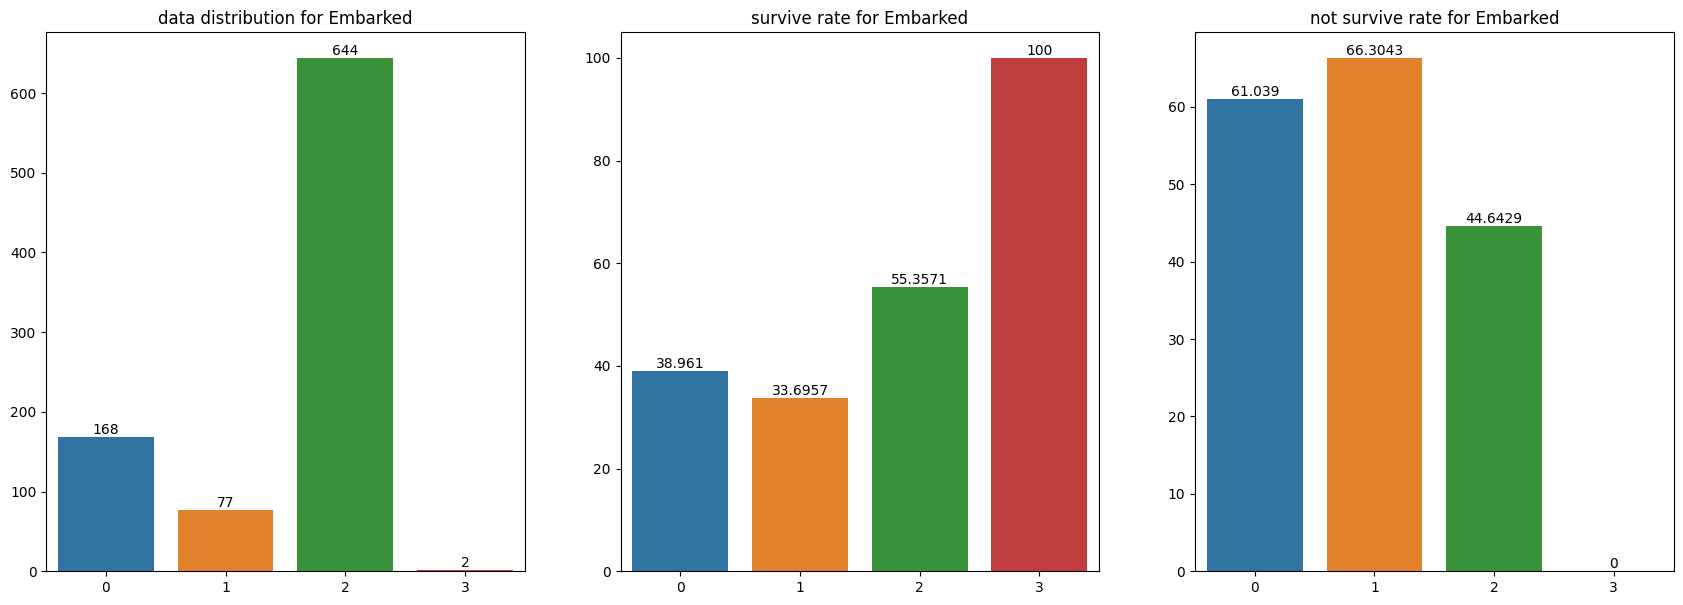

In [12]:
class_cnt            = train_df['Embarked'].value_counts()
survive, not_survive = cal_survival_rate(train_df, 'Embarked')

_, ax = plt.subplots(1, 3, figsize = (21, 7))

draw_barplot(ax[0], class_cnt.index, class_cnt.values, title = 'data distribution for Embarked')
draw_barplot(ax[1], class_cnt.index,          survive, title =      'survive rate for Embarked')
draw_barplot(ax[2], class_cnt.index,      not_survive, title =  'not survive rate for Embarked')

In [13]:
x      = train_df.drop(['Survived'], axis = 1)
y      = train_df['Survived']

scaler = StandardScaler()
x      = scaler.fit_transform(x)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size = 0.25, shuffle = True,
                                                      stratify = y, random_state = 99)

In [14]:
svm = SVC(C = 100)
svm.fit(train_x, train_y)

preds = svm.predict(train_x)
print('train report\n', classification_report(train_y, preds))
print(f'train auc : {roc_auc_score(train_y, preds):.3f}\n')

preds = svm.predict(valid_x)
print('valid report\n', classification_report(valid_y, preds))
print(f'valid auc : {roc_auc_score(valid_y, preds):.3f} \n')

train report
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       412
           1       0.91      0.73      0.81       256

    accuracy                           0.87       668
   macro avg       0.88      0.84      0.86       668
weighted avg       0.87      0.87      0.87       668

train auc : 0.844

valid report
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       137
           1       0.78      0.65      0.71        86

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223

valid auc : 0.767 



In [15]:
reg = LogisticRegression()
reg.fit(train_x, train_y)

preds = reg.predict(train_x)
print('train report\n', classification_report(train_y, preds), '\n')
print(f'train auc : {roc_auc_score(train_y, preds):.3f}\n')

preds = reg.predict(valid_x)
print('valid report\n', classification_report(valid_y, preds), '\n')
print(f'valid auc : {roc_auc_score(valid_y, preds):.3f} \n')

train report
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       412
           1       0.75      0.70      0.73       256

    accuracy                           0.80       668
   macro avg       0.79      0.78      0.78       668
weighted avg       0.79      0.80      0.80       668
 

train auc : 0.779

valid report
               precision    recall  f1-score   support

           0       0.84      0.81      0.83       137
           1       0.71      0.76      0.73        86

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223
 

valid auc : 0.783 



In [17]:
from pycaret.classification import *

In [20]:
clf_setup = setup(data = train_df, target = 'Survived',
                  train_size = 0.75, fold = 10)

,Description,Value
0,Session id,6564
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 7)"
4,Transformed data shape,"(891, 7)"
5,Transformed train set shape,"(668, 7)"
6,Transformed test set shape,"(223, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [21]:
best_model = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8069,0.8623,0.7146,0.7781,0.7381,0.5861,0.5941,0.1480
gbc,Gradient Boosting Classifier,0.8024,0.8559,0.6828,0.7858,0.7234,0.5715,0.5807,0.2480
catboost,CatBoost Classifier,0.8129,0.8518,0.6985,0.7943,0.7377,0.5939,0.6014,0.8800
lda,Linear Discriminant Analysis,0.7979,0.8434,0.6862,0.7735,0.7209,0.5637,0.5717,0.1920
ada,Ada Boost Classifier,0.7918,0.8426,0.7106,0.7482,0.7242,0.5577,0.5623,0.2750
qda,Quadratic Discriminant Analysis,0.7843,0.8425,0.6862,0.7409,0.7077,0.5375,0.5428,0.2630
lr,Logistic Regression,0.7934,0.8423,0.7023,0.7593,0.7220,0.5584,0.5663,0.2430
rf,Random Forest Classifier,0.7769,0.8363,0.6909,0.7229,0.7003,0.5238,0.5296,0.2870
nb,Naive Bayes,0.7738,0.8245,0.7138,0.7049,0.7069,0.5230,0.5255,0.2550
et,Extra Trees Classifier,0.7649,0.8091,0.6635,0.7152,0.6814,0.4968,0.5034,0.1880


In [25]:
model = create_model('catboost')
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8209,0.8548,0.6400,0.8421,0.7273,0.5976,0.6101
1,0.7910,0.7586,0.5600,0.8235,0.6667,0.5224,0.5430
2,0.8060,0.8166,0.8077,0.7241,0.7636,0.5999,0.6025
3,0.7910,0.8860,0.7692,0.7143,0.7407,0.5661,0.5672
4,0.9104,0.9160,0.8462,0.9167,0.8800,0.8088,0.8104
5,0.7612,0.8354,0.5385,0.7778,0.6364,0.4672,0.4847
6,0.8507,0.9334,0.7692,0.8333,0.8000,0.6813,0.6826
7,0.7612,0.8039,0.6538,0.7083,0.6800,0.4900,0.4910
8,0.8333,0.8571,0.8000,0.7692,0.7843,0.6486,0.6489


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7910,0.7890,0.6000,0.7895,0.6818,0.5305,0.5416
1,0.8060,0.8419,0.5600,0.8750,0.6829,0.5526,0.5812
2,0.7910,0.8602,0.7692,0.7143,0.7407,0.5661,0.5672
3,0.7612,0.8447,0.7308,0.6786,0.7037,0.5042,0.5051
4,0.9403,0.9489,0.8846,0.9583,0.9200,0.8725,0.8743
5,0.7910,0.8776,0.4615,1.0000,0.6316,0.5120,0.5866
6,0.8507,0.9240,0.7692,0.8333,0.8000,0.6813,0.6826
7,0.8209,0.8114,0.7308,0.7917,0.7600,0.6175,0.6188
8,0.8030,0.8478,0.6800,0.7727,0.7234,0.5714,0.5742


Fitting 10 folds for each of 10 candidates, totalling 100 fits


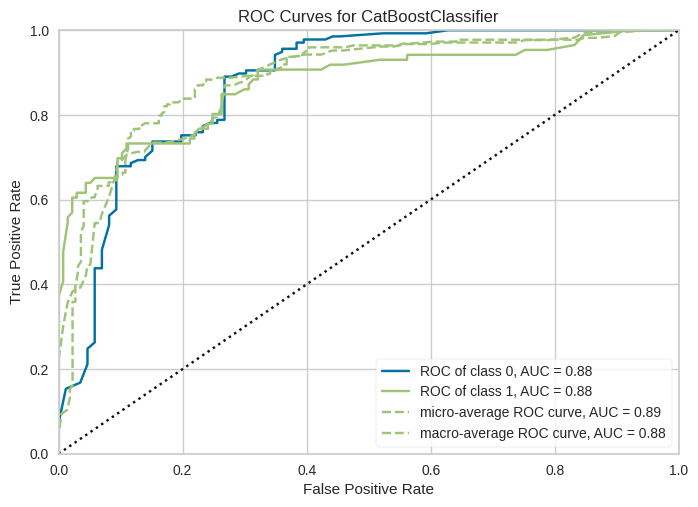

In [26]:
plot_model(tuned_model)